In [1]:
from company_analysis import analyze_company
from comparative_analysis import compare_companies

from data_extraction import extract_financial_data
from ratios import calculate_ratios_timeseries

from visualization import plot_metrics, plot_ratios, plot_comparison

import yfinance as yf
import matplotlib.pyplot as plt

from dcf_analysis import (
    calculate_historical_growth, get_risk_free_rate,
    calculate_market_return, calculate_effective_tax_rate, calculate_wacc,
    dcf_valuation, print_dcf_report
)

from dcf_sensitivity_analysis import (
    dcf_sensitivity_analysis, dcf_comparison
)

from dcf_monte_carlo import (
    calculate_growth_volatility, dcf_monte_carlo, print_monte_carlo_report,
    plot_monte_carlo_distribution, monte_carlo_comparison
)

In [2]:
"""
MAIN.py - Unified Financial Analysis Interface
==============================================
Single entry point for comprehensive company financial analysis.

Usage:
    from MAIN import FinancialAnalysis
    
    # Single company analysis
    fa = FinancialAnalysis(ticker='AAPL')
    fa.analyze_company()
    fa.dcf_analysis()
    fa.mc_dcf_analysis()
    fa.plot_monte_carlo_distribution()
    
    # Multi-company comparison
    fa = FinancialAnalysis(tickers=['AAPL', 'MSFT', 'GOOGL'])
    fa.compare_companies()
    fa.plot_comparison(metrics=['roe', 'net_margin'])
    fa.monte_carlo_comparison()
"""

"\nMAIN.py - Unified Financial Analysis Interface\n==============================================\nSingle entry point for comprehensive company financial analysis.\n\nUsage:\n    from MAIN import FinancialAnalysis\n\n    # Single company analysis\n    fa = FinancialAnalysis(ticker='AAPL')\n    fa.analyze_company()\n    fa.dcf_analysis()\n    fa.mc_dcf_analysis()\n    fa.plot_monte_carlo_distribution()\n\n    # Multi-company comparison\n    fa = FinancialAnalysis(tickers=['AAPL', 'MSFT', 'GOOGL'])\n    fa.compare_companies()\n    fa.plot_comparison(metrics=['roe', 'net_margin'])\n    fa.monte_carlo_comparison()\n"

In [3]:
class FinancialAnalysis:
    """
    Unified interface for financial analysis operations.
    
    This class provides a clean API for all analysis functions, supporting both
    single-company deep dives and multi-company comparative analysis.
    
    Attributes:
        ticker (str): Single company ticker for detailed analysis
        tickers (list): Multiple tickers for comparative analysis
        results (dict): Stores DCF valuation results
        mc_results (dict): Stores Monte Carlo DCF simulation results
    
    Examples:
        # Single company workflow
        >>> fa = FinancialAnalysis(ticker='AAPL')
        >>> fa.analyze_company()  # Latest ratios
        >>> fa.plot_ratios(['roe', 'debt_to_equity'])  # Time series
        >>> fa.dcf_analysis()  # Intrinsic valuation
        >>> fa.mc_dcf_analysis()  # Probabilistic valuation
        
        # Multi-company workflow
        >>> fa = FinancialAnalysis(tickers=['AAPL', 'MSFT', 'GOOGL'])
        >>> comparison = fa.compare_companies()  # Side-by-side ratios
        >>> fa.plot_comparison(['roe', 'net_margin'])  # Visual comparison
        >>> mc_comp = fa.monte_carlo_comparison()  # Probabilistic comparison
    """
    
    def __init__(self, ticker=None, tickers=None):
        """
        Initialize FinancialAnalysis object.
        
        Args:
            ticker (str, optional): Single ticker for detailed analysis
            tickers (list, optional): List of tickers for comparative analysis
            
        Raises:
            ValueError: If neither ticker nor tickers is provided
        """
        self.ticker = ticker
        self.tickers = tickers if tickers is not None else []
        self.results = None
        self.mc_results = None
        
        # Validate inputs
        if not ticker and not self.tickers:
            raise ValueError("Must provide either 'ticker' or 'tickers'")
    
    # ================================================================
    # SINGLE COMPANY ANALYSIS
    # ================================================================
    
    def analyze_company(self, tax_rate=0.21, period='quarterly'):
        """
        Analyze most recent financial period for the company.
        
        Extracts latest financial data and calculates key ratios:
        - Profitability: ROE, ROA, Net Margin
        - Liquidity: Current Ratio, Quick Ratio
        - Leverage: Debt/Equity
        - Cash Flow: Free Cash Flow
        
        Args:
            tax_rate (float): Corporate tax rate for FCF calculation (default: 0.21)
            period (str): 'quarterly' or 'annual' data (default: 'quarterly')
        
        Returns:
            dict: Nested dictionary with ratio categories and values
        
        Example:
            >>> fa = FinancialAnalysis(ticker='AAPL')
            >>> results = fa.analyze_company(period='annual')
            >>> print(results['Profitability']['ROE (%)'])
        """
        if not self.ticker:
            raise ValueError("ticker required for analyze_company()")
        return analyze_company(self.ticker, tax_rate=tax_rate, period=period)
    
    def plot_metrics(self, metrics=[], period='quarterly'):
        """
        Plot time series of raw financial statement metrics.
        
        Visualizes historical trends for metrics like revenue, EBIT, cash, etc.
        Useful for understanding absolute performance over time.
        
        Args:
            metrics (list): List of metric names from financial statements
                Valid options: 'revenue', 'ebit', 'net_income', 'cash', 
                              'total_debt', 'operating_cf', etc.
            period (str): 'quarterly' or 'annual' (default: 'quarterly')
        
        Example:
            >>> fa = FinancialAnalysis(ticker='AAPL')
            >>> fa.plot_metrics(['revenue', 'net_income', 'cash'], period='annual')
        """
        if not self.ticker:
            raise ValueError("ticker required for plot_metrics()")
        plot_metrics(self.ticker, metrics=metrics, period=period)
    
    def plot_ratios(self, ratios=[], period='quarterly', tax_rate=0.21):
        """
        Plot time series of calculated financial ratios.
        
        Visualizes ratio trends to identify improving/deteriorating performance.
        More informative than absolute metrics for cross-period comparison.
        
        Args:
            ratios (list): List of ratio names to plot
                Valid options: 'roe', 'roa', 'net_margin', 'current_ratio',
                              'quick_ratio', 'debt_to_equity', 'fcf'
            period (str): 'quarterly' or 'annual' (default: 'quarterly')
            tax_rate (float): Tax rate for FCF calculation (default: 0.21)
        
        Example:
            >>> fa = FinancialAnalysis(ticker='AAPL')
            >>> fa.plot_ratios(['roe', 'debt_to_equity'], period='annual')
        """
        if not self.ticker:
            raise ValueError("ticker required for plot_ratios()")
        plot_ratios(self.ticker, ratios=ratios, period=period, tax_rate=tax_rate)
    
    # ================================================================
    # DCF VALUATION (Single Company)
    # ================================================================
    
    def dcf_analysis(self, growth_rate=None, terminal_growth=0.03, 
                     risk_free_rate=None, market_return=None, 
                     tax_rate=None, years=5):
        """
        Perform Discounted Cash Flow (DCF) valuation.
        
        Calculates intrinsic value by projecting future free cash flows and
        discounting them to present value using WACC. All parameters are
        auto-calculated from historical data if not provided.
        
        Process:
        1. Extract historical FCF and calculate growth rate (CAGR)
        2. Project FCF for next N years
        3. Calculate terminal value (perpetuity growth model)
        4. Discount all cash flows using WACC
        5. Calculate equity value per share
        
        Args:
            growth_rate (float, optional): FCF growth rate (auto: 80% of historical)
            terminal_growth (float): Perpetual growth rate (default: 0.03)
            risk_free_rate (float, optional): Risk-free rate (auto: 10Y Treasury)
            market_return (float, optional): Market return (auto: S&P 500 CAGR)
            tax_rate (float, optional): Corporate tax rate (auto: effective rate)
            years (int): Projection period (default: 5)
        
        Returns:
            dict: Valuation results including fair value, upside %, assumptions
        
        Side Effects:
            - Stores results in self.results
            - Prints formatted DCF report
        
        Example:
            >>> fa = FinancialAnalysis(ticker='AAPL')
            >>> results = fa.dcf_analysis()  # Auto-calculated parameters
            >>> print(f"Fair Value: ${results['fair_value']:.2f}")
            >>> print(f"Upside: {results['upside_pct']:.1f}%")
        """
        if not self.ticker:
            raise ValueError("ticker required for dcf_analysis()")
        
        self.results = dcf_valuation(
            self.ticker, 
            growth_rate=growth_rate, 
            terminal_growth=terminal_growth,
            risk_free_rate=risk_free_rate, 
            market_return=market_return, 
            tax_rate=tax_rate, 
            years=years
        )
        
        print_dcf_report(self.results)
        return self.results
    
    def dcf_scenarios(self, tax_rate=None, risk_free_rate=None, market_return=None):
        """
        Run DCF under Bear/Base/Bull scenarios.
        
        Performs sensitivity analysis by varying growth assumptions:
        - Bear: 50% of historical growth
        - Base: 80% of historical growth (realistic)
        - Bull: 120% of historical growth
        
        Args:
            tax_rate (float, optional): Corporate tax rate (auto-calculated)
            risk_free_rate (float, optional): Risk-free rate (auto-calculated)
            market_return (float, optional): Market return (auto-calculated)
        
        Returns:
            pd.DataFrame: Scenarios with fair values and upside percentages
        
        Side Effects:
            - Prints scenario analysis table
            - Prints investment decision recommendation
        
        Example:
            >>> fa = FinancialAnalysis(ticker='AAPL')
            >>> scenarios = fa.dcf_scenarios()
            >>> print(scenarios)
        """
        if not self.ticker:
            raise ValueError("ticker required for dcf_scenarios()")
        
        return dcf_sensitivity_analysis(
            self.ticker, 
            tax_rate=tax_rate, 
            risk_free_rate=risk_free_rate, 
            market_return=market_return
        )
    
    def mc_dcf_analysis(self, n_simulations=10000, years=5, terminal_growth=0.03,
                        tax_rate=None, risk_free_rate=None, market_return=None):
        """
        Monte Carlo simulation of DCF valuation.
        
        Runs thousands of DCF calculations with randomized parameters to
        generate probability distribution of fair values. Accounts for
        uncertainty in growth rates, WACC, and terminal value.
        
        Randomization:
        - Growth rate: Normal distribution (mean=historical, std=historical volatility)
        - WACC: Normal distribution (±1.5% std dev)
        - Terminal growth: Normal distribution (±0.5% std dev)
        
        Args:
            n_simulations (int): Number of Monte Carlo runs (default: 10000)
            years (int): Projection period (default: 5)
            terminal_growth (float): Mean terminal growth rate (default: 0.03)
            tax_rate (float, optional): Corporate tax rate (auto-calculated)
            risk_free_rate (float, optional): Risk-free rate (auto-calculated)
            market_return (float, optional): Market return (auto-calculated)
        
        Returns:
            dict: Probabilistic results including:
                - mean/median fair value
                - confidence intervals (10th-90th percentile)
                - probability of undervaluation
                - recommendation (STRONG BUY / BUY / HOLD / SELL / STRONG SELL)
        
        Side Effects:
            - Stores results in self.mc_results
            - Prints Monte Carlo report with statistics
        
        Example:
            >>> fa = FinancialAnalysis(ticker='AAPL')
            >>> mc_results = fa.mc_dcf_analysis(n_simulations=10000)
            >>> print(f"P(Undervalued): {mc_results['prob_undervalued']:.1f}%")
            >>> print(f"Recommendation: {mc_results['recommendation']}")
        """
        if not self.ticker:
            raise ValueError("ticker required for mc_dcf_analysis()")
        
        self.mc_results = dcf_monte_carlo(
            self.ticker, 
            n_simulations=n_simulations, 
            years=years, 
            terminal_growth=terminal_growth,
            tax_rate=tax_rate, 
            risk_free_rate=risk_free_rate, 
            market_return=market_return
        )
        
        print_monte_carlo_report(self.mc_results)
        return self.mc_results
    
    def plot_monte_carlo_distribution(self):
        """
        Visualize Monte Carlo DCF results.
        
        Creates two plots:
        1. Histogram: Distribution of fair values with key percentiles
        2. Cumulative: Probability of exceeding each price level
        
        Requires:
            Must call mc_dcf_analysis() first to generate results
        
        Raises:
            ValueError: If mc_results not available
        
        Example:
            >>> fa = FinancialAnalysis(ticker='AAPL')
            >>> fa.mc_dcf_analysis()
            >>> fa.plot_monte_carlo_distribution()  # Shows matplotlib plots
        """
        if self.mc_results is None:
            raise ValueError("Must run mc_dcf_analysis() first")
        
        plot_monte_carlo_distribution(self.mc_results)
    
    # ================================================================
    # COMPARATIVE ANALYSIS (Multiple Companies)
    # ================================================================
    
    def compare_companies(self, tax_rate=0.21, period='quarterly'):
        """
        Compare financial ratios across multiple companies.
        
        Generates side-by-side comparison table for latest period.
        Useful for peer analysis and relative valuation.
        
        Args:
            tax_rate (float): Corporate tax rate for FCF (default: 0.21)
            period (str): 'quarterly' or 'annual' (default: 'quarterly')
        
        Returns:
            pd.DataFrame: Companies as rows, ratios as columns
        
        Metrics included:
            - ROE, ROA, Net Margin
            - Current Ratio, Quick Ratio
            - Debt/Equity
            - Free Cash Flow
        
        Example:
            >>> fa = FinancialAnalysis(tickers=['AAPL', 'MSFT', 'GOOGL'])
            >>> comparison = fa.compare_companies(period='annual')
            >>> print(comparison)
            >>> # Find best ROE
            >>> best = comparison['ROE (%)'].idxmax()
        """
        if not self.tickers:
            raise ValueError("tickers required for compare_companies()")
        
        return compare_companies(self.tickers, tax_rate=tax_rate, period=period)
    
    def plot_comparison(self, metrics=[], period='quarterly', tax_rate=0.21):
        """
        Plot time series comparison of ratios across companies.
        
        Overlays multiple companies on same chart for each metric.
        Excellent for identifying relative trends and performance divergence.
        
        Args:
            metrics (list): Ratio names to compare
                Valid: 'roe', 'roa', 'net_margin', 'current_ratio', 'debt_to_equity'
            period (str): 'quarterly' or 'annual' (default: 'quarterly')
            tax_rate (float): Tax rate for FCF (default: 0.21)
        
        Example:
            >>> fa = FinancialAnalysis(tickers=['AAPL', 'MSFT', 'GOOGL'])
            >>> fa.plot_comparison(['roe', 'net_margin'], period='annual')
        """
        if not self.tickers:
            raise ValueError("tickers required for plot_comparison()")
        
        plot_comparison(self.tickers, metrics=metrics, period=period, tax_rate=tax_rate)
    
    def dcf_comparison(self, tax_rate=None):
        """
        Compare DCF valuations across multiple companies.
        
        Runs deterministic DCF for each company with auto-calculated parameters.
        Returns comparison table sorted by upside potential.
        
        Args:
            tax_rate (float, optional): Tax rate (auto-calculated per company if None)
        
        Returns:
            pd.DataFrame: Companies ranked by upside, includes:
                - Current Price
                - Fair Value
                - Upside (%)
                - Growth Rate used
                - WACC
        
        Example:
            >>> fa = FinancialAnalysis(tickers=['AAPL', 'MSFT', 'GOOGL'])
            >>> dcf_comp = fa.dcf_comparison()
            >>> print(dcf_comp.head())  # Top opportunities
        """
        if not self.tickers:
            raise ValueError("tickers required for dcf_comparison()")
        
        return dcf_comparison(self.tickers, tax_rate=tax_rate)
    
    def monte_carlo_comparison(self, n_simulations=10000):
        """
        Compare Monte Carlo DCF valuations across companies.
        
        Runs probabilistic valuation for each company and aggregates results.
        Provides probability-based ranking for investment decision-making.
        
        Args:
            n_simulations (int): Monte Carlo runs per company (default: 10000)
        
        Returns:
            pd.DataFrame: Companies sorted by P(Undervalued), includes:
                - Current Price
                - Mean/Median Fair Value
                - P(Undervalued) %
                - Expected Upside %
                - 80% Confidence Interval
                - Recommendation
        
        Processing time:
            ~5-10 seconds per company with 10,000 simulations
        
        Example:
            >>> fa = FinancialAnalysis(tickers=['AAPL', 'MSFT', 'GOOGL'])
            >>> mc_comp = fa.monte_carlo_comparison()
            >>> # Filter strong buys
            >>> strong_buys = mc_comp[mc_comp['Recommendation'] == 'STRONG BUY']
        """
        if not self.tickers:
            raise ValueError("tickers required for monte_carlo_comparison()")
        
        return monte_carlo_comparison(self.tickers, n_simulations=n_simulations)


MONTE CARLO DCF ANALYSIS: AAPL
Simulations: 10,000

Current Market Price: $278.78

Probabilistic Fair Value Estimates
----------------------------------------------------------------------
  Mean Fair Value.................... $     78.20
  Median Fair Value.................. $     74.28
  Standard Deviation................. $     19.62

Confidence Intervals
----------------------------------------------------------------------
  10th Percentile (Pessimistic)...... $     57.74
  25th Percentile.................... $     64.13
  75th Percentile.................... $     87.95
  90th Percentile (Optimistic)....... $    103.78
  80% Confidence Range............... $57.74 - $103.78

Probabilistic Assessment
----------------------------------------------------------------------
  Probability Undervalued............        0.0%
  Expected Upside (Mean).............      -71.9%
  Expected Upside (Median)...........      -73.4%

Historical Parameters Used
-------------------------------------

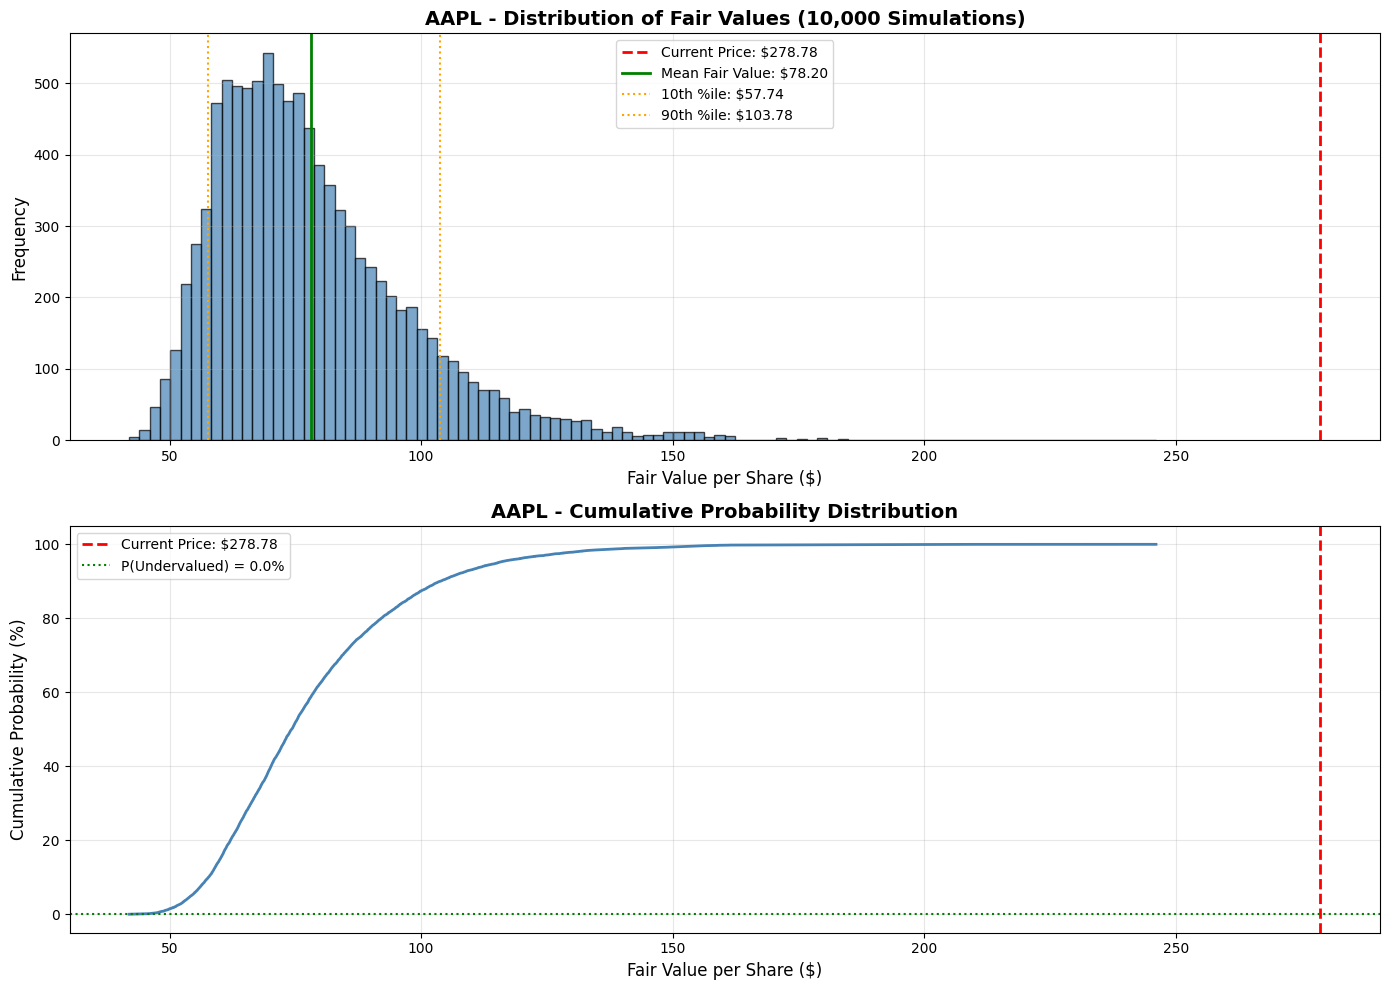

In [4]:
fa = FinancialAnalysis('AAPL')
fa.mc_dcf_analysis()
fa.plot_monte_carlo_distribution()

In [5]:
""" Function necessary to visualize potential stock splits """

def check(ticker):
    data = yf.download(ticker, start='1995-1-1')
    
    closing_p = data['Close']
    ret = data['Close'].pct_change()
    
    closing_p.plot()
    ret.plot()

C:\Users\matte\AppData\Local\Temp\ipykernel_25076\950792797.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='1995-1-1')
[*********************100%***********************]  1 of 1 completed


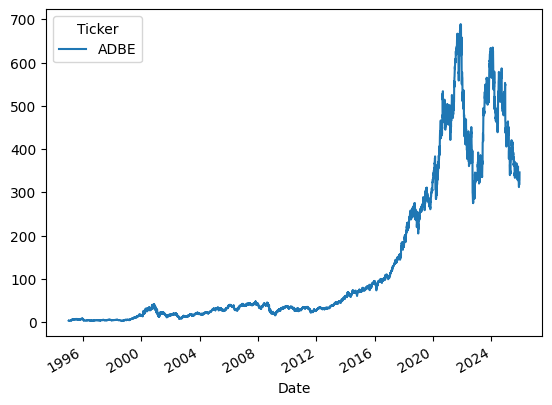

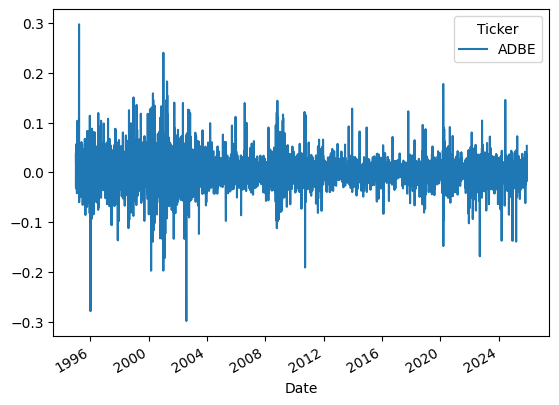

In [6]:
check('ADBE')